<a href="https://colab.research.google.com/github/andrew-veriga/Tensorflow-labs/blob/master/C4_W1_Lab_Stack_Semantics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Semantics in Trax: Ungraded Lab

In this ungraded lab, we will explain the stack semantics in Trax. This will help in understanding how to use layers like `Select` and `Residual` which operates on elements in the stack. If you've taken a computer science class before, you will recall that a stack is a data structure that follows the Last In, First Out (LIFO) principle. That is, whatever is the latest element that is pushed into the stack will also be the first one to be popped out. If you're not yet familiar with stacks, then you may find this [short tutorial](https://www.tutorialspoint.com/python_data_structure/python_stack.htm) useful. In a nutshell, all you really need to remember is it puts elements one on top of the other. You should be aware of what is on top of the stack to know which element you will be popping. You will see this in the discussions below. Let's get started!

## Imports

In [ ]:
import numpy as np              # regular ol' numpy
from trax import layers as tl   # core building block
from trax import shapes         # data signatures: dimensionality and type
from trax import fastmath       # uses jax, offers numpy on steroids

## 1. The tl.Serial Combinator is Stack Oriented.

To understand how stack-orientation works in [Trax](https://trax-ml.readthedocs.io/en/latest/), most times one will be using the `Serial` layer. We will define two simple [Function layers](https://trax-ml.readthedocs.io/en/latest/notebooks/layers_intro.html?highlight=fn#With-the-Fn-layer-creating-function.): 1) Addition and 2) Multiplication.

Suppose we want to make the simple calculation (3 + 4) * 15 + 3. `Serial` will perform the calculations in the following manner `3` `4` `add` `15` `mul` `3` `add`. The steps of the calculation are shown in the table below. The first column shows the operations made on the stack and the second column the output of those operations. Moreover, the rightmost element in the second column represents the top of the stack (e.g. in the second row, `Push(3)` pushes `3 ` on top of the stack and `4` is now under it).

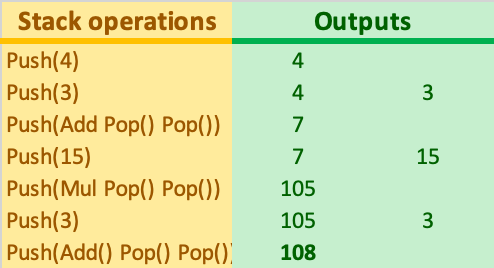

After processing all the stack contains 108 which is the answer to our simple computation.

From this, the following can be concluded: a stack-based layer has only one way to handle data, by taking one piece of data from atop the stack, termed popping, and putting data back atop the stack, termed pushing. Any expression that can be written conventionally, can be written in this form and thus be amenable to being interpreted by a stack-oriented layer like `Serial`.

### Coding the example in the table:

**Defining addition**

In [ ]:
def Addition():
    layer_name = "Addition"  # don't forget to give your custom layer a name to identify

    # Custom function for the custom layer
    def func(x, y):
        return x + y

    return tl.Fn(layer_name, func)


# Test it
add = Addition()

# Inspect properties
print("-- Properties --")
print("name :", add.name)
print("expected inputs :", add.n_in)
print("promised outputs :", add.n_out, "\n")

# Inputs
x = np.array([3])
y = np.array([4])
print("-- Inputs --")
print("x :", x, "\n")
print("y :", y, "\n")

# Outputs
z = add((x, y))
print("-- Outputs --")
print("z :", z)

**Defining multiplication**

In [ ]:
def Multiplication():
    layer_name = (
        "Multiplication"  # don't forget to give your custom layer a name to identify
    )

    # Custom function for the custom layer
    def func(x, y):
        return x * y

    return tl.Fn(layer_name, func)


# Test it
mul = Multiplication()

# Inspect properties
print("-- Properties --")
print("name :", mul.name)
print("expected inputs :", mul.n_in)
print("promised outputs :", mul.n_out, "\n")

# Inputs
x = np.array([7])
y = np.array([15])
print("-- Inputs --")
print("x :", x, "\n")
print("y :", y, "\n")

# Outputs
z = mul((x, y))
print("-- Outputs --")
print("z :", z)

**Implementing the computations using Serial combinator.**

In [ ]:
# Serial combinator
serial = tl.Serial(
    Addition(), Multiplication(), Addition()  # add 3 + 4  # multiply result by 15
)

# Initialization
x = (np.array([3]), np.array([4]), np.array([15]), np.array([3]))  # input

serial.init(shapes.signature(x))  # initializing serial instance


print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print("name :", serial.name)
print("sublayers :", serial.sublayers)
print("expected inputs :", serial.n_in)
print("promised outputs :", serial.n_out, "\n")

# Inputs
print("-- Inputs --")
print("x :", x, "\n")

# Outputs
y = serial(x)
print("-- Outputs --")
print("y :", y)

The example with the two simple adition and multiplication functions that where coded together with the serial combinator show how stack semantics work in `Trax`.

## 2. The tl.Select combinator in the context of the Serial combinator

Having understood how stack semantics work in `Trax`, we will demonstrate how the [tl.Select](https://trax-ml.readthedocs.io/en/latest/trax.layers.html?highlight=select#trax.layers.combinators.Select) combinator works.

### First example of tl.Select

Suppose we want to make the simple calculation (3 + 4) * 3 + 4. We can use `Select` to perform the calculations in the following manner:

1. `4`
2. `3`
3. `tl.Select([0,1,0,1])` 
4. `add` 
5. `mul` 
6. `add`. 

The `tl.Select` requires a list or tuple of 0-based indices to select elements relative to the top of the stack. For our example, the top of the stack is `3` (which is at index 0) then `4` (index 1) and we Select to add in an ordered manner to the top of the stack which after the command is `3` `4` `3` `4`. The steps of the calculation for our example are shown in the table below. As in the previous table each column shows the contents of the stack and the outputs after the operations are carried out.

<div style="text-align:center" width="20px"><img src="https://github.com/andrew-veriga/Tensorflow-labs/blob/master/Stack2.png?raw=1" /></div>

After processing all the inputs the stack contains 25 which is the answer we get above.

In [ ]:
serial = tl.Serial(tl.Select([0, 1, 0, 1]), Addition(), Multiplication(), Addition())

# Initialization
x = (np.array([3]), np.array([4]))  # input

serial.init(shapes.signature(x))  # initializing serial instance


print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print("name :", serial.name)
print("sublayers :", serial.sublayers)
print("expected inputs :", serial.n_in)
print("promised outputs :", serial.n_out, "\n")

# Inputs
print("-- Inputs --")
print("x :", x, "\n")

# Outputs
y = serial(x)
print("-- Outputs --")
print("y :", y)

### Second example of tl.Select

Suppose we want to make the simple calculation (3 + 4) * 4. We can use `Select` to perform the calculations in the following manner:

1. `4`
2. `3`
3. `tl.Select([0,1,0,1])` 
4. `add` 
5. `tl.Select([0], n_in=2)`
6. `mul`

The example is a bit contrived but it demonstrates the flexibility of the command. The second `tl.Select` pops two elements (specified in n_in) from the stack starting from index 0 (i.e. top of the stack). This means that `7` and `3 ` will be popped out because `n_in = 2`) but only `7` is placed back on top because it only selects `[0]`.  As in the previous table each column shows the contents of the stack and the outputs after the operations are carried out.

<div style="text-align:center" width="20px"><img src="https://github.com/andrew-veriga/Tensorflow-labs/blob/master/Stack3.png?raw=1" /></div>

After processing all the inputs the stack contains 28 which is the answer we get above.

In [ ]:
serial = tl.Serial(
    tl.Select([0, 1, 0, 1]), Addition(), tl.Select([0], n_in=2), Multiplication()
)

# Initialization
x = (np.array([3]), np.array([4]))  # input

serial.init(shapes.signature(x))  # initializing serial instance


print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print("name :", serial.name)
print("sublayers :", serial.sublayers)
print("expected inputs :", serial.n_in)
print("promised outputs :", serial.n_out, "\n")

# Inputs
print("-- Inputs --")
print("x :", x, "\n")

# Outputs
y = serial(x)
print("-- Outputs --")
print("y :", y)

**In summary, what Select does in this example is a copy of the inputs in order to be used further along in the stack of operations.**

## 3. The tl.Residual combinator in the context of the Serial combinator

### tl.Residual

[Residual networks](https://arxiv.org/pdf/1512.03385.pdf) are frequently used to make deep models easier to train and you will be using it in the assignment as well. Trax already has a built in layer for this. The [Residual layer](https://trax-ml.readthedocs.io/en/latest/trax.layers.html?highlight=residual#trax.layers.combinators.Residual) computes the element-wise *sum* of the *stack-top* input with the output of the layer series. Let's first see how it is used in the code below:

In [ ]:
# Let's define a Serial network
serial = tl.Serial(
    # Practice using Select again by duplicating the first two inputs
    tl.Select([0, 1, 0, 1]),
    # Place a Residual layer that skips over the Fn: Addition() layer
    tl.Residual(Addition())
)

print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print("name :", serial.name)
print("expected inputs :", serial.n_in)
print("promised outputs :", serial.n_out, "\n")

Here, we use the Serial combinator to define our model. The inputs first goes through a `Select` layer, followed by a `Residual` layer which passes the `Fn: Addition()` layer as an argument. What this means is the `Residual` layer will take the stack top input at that point and add it to the output of the `Fn: Addition()` layer. You can picture it like the diagram the below, where `x1` and `x2` are the inputs to the model:

<img src="https://github.com/andrew-veriga/Tensorflow-labs/blob/master/residual_example_add.png?raw=1" width="400"/></div>

Now, let's try running our model with some sample inputs and see the result:

In [ ]:
# Inputs
x1 = np.array([3])
x2 = np.array([4])
print("-- Inputs --")
print("(x1, x2) :", (x1, x2), "\n")

# Outputs
y = serial((x1, x2))
print("-- Outputs --")
print("y :", y)

As you can see, the `Residual` layer remembers the stack top input (i.e. `3`) and adds it to the result of the `Fn: Addition()` layer (i.e. `3 + 4 = 7`). The output of `Residual(Addition()` is then `3 + 7 = 10` and is pushed onto the stack. 

On a different note, you'll notice that the `Select` layer has 4 outputs but the `Fn: Addition()` layer only pops 2 inputs from the stack. This means the duplicate inputs (i.e. the 2 rightmost arrows of the `Select` outputs in the figure above) remain in the stack. This is why you still see it in the output of our simple serial network (i.e. `array([3]), array([4])`). This is useful if you want to use these duplicate inputs in another layer further down the network.

### Modifying the network

To strengthen your understanding, you can modify the network above and examine the outputs you get. For example, you can pass the `Fn: Multiplication()` layer instead in the `Residual` block:

In [ ]:
# model definition
serial = tl.Serial(
    tl.Select([0, 1, 0, 1]), 
    tl.Residual(Multiplication())
)

print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print("name :", serial.name)
print("expected inputs :", serial.n_in)
print("promised outputs :", serial.n_out, "\n")

This means you'll have a different output that will be added to the stack top input saved by the Residual block. The diagram becomes like this:

<img src="https://github.com/andrew-veriga/Tensorflow-labs/blob/master/residual_example_multiply.png?raw=1" width="400"/></div>


And you'll get `3 + (3 * 4) = 15` as output of the `Residual` block:

In [ ]:
# Inputs
x1 = np.array([3])
x2 = np.array([4])
print("-- Inputs --")
print("(x1, x2) :", (x1, x2), "\n")

# Outputs
y = serial((x1, x2))
print("-- Outputs --")
print("y :", y)

#### Congratulations! In this lab, we described how stack semantics work with Trax layers such as Select and Residual. You will be using these in the assignment and you can go back to this lab in case you want to review its usage.